# Задание 2. Типы шума на изображении, моделирование аддитивного шума, алгоритмы фильтрации изображений.

### 1) Моделирование аддитивного шума. (Постоянный шум)

**Импортируем OpenCV и прочее**

In [54]:
import cv2
import statistics as st
import math
import time
from IPython.display import Image
from matplotlib import pyplot as plt
import numpy as np
import random
print(cv2.__version__)

4.0.1


**Добавляем изображение**

In [55]:
img = cv2.imread("img1.jpg")

**Изображение:**

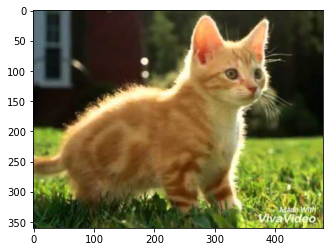

In [56]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

**Функция генерации шума с равномерным распределением.** (img - изображение для зашумления, p - вероятность шума, color - цвет шума(white - белый, bw - чёрный и белый)

In [57]:
def generate_constant_noise(img, p=0.1, color='white'):
    for i, row in enumerate(img):
        for j, _ in enumerate(row):
            if random.random() < p:
                if color == 'white' or random.random() < 0.5:
                    img[i][j] = [255, 255, 255]
                else:
                    img[i][j] = [0, 0, 0]

**Зашумляем изображение**

In [58]:
generate_constant_noise(img)

**Изображение с шумом:**

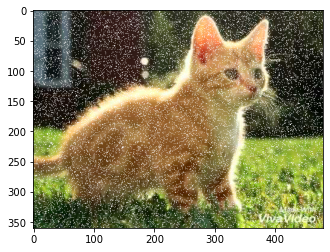

In [59]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

### 2) Удаление шума. Медианный фильтр

**Изображение:**

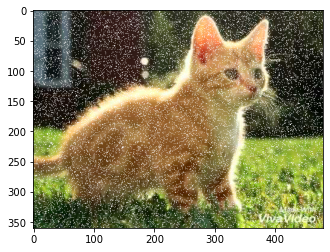

In [60]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

**OpenCV реализация**

In [61]:
start_time = time.time()
img_cv = cv2.medianBlur(img, 3)
end_time = time.time()

**Изображение:**

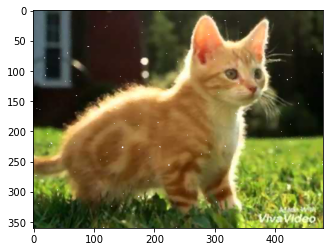

In [62]:
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

**Время работы:**

In [63]:
print(end_time - start_time)

0.0010006427764892578


**Реализуем медианный фильтр**

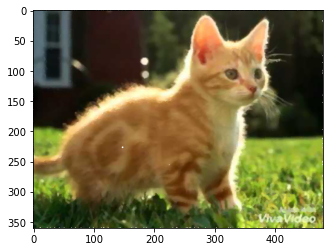

In [64]:
start_time = time.time()

img_my = img
for y in range(img.shape[0]):
    for x in range(img.shape[1]):
        img_my[y,x]=img[y,x]
members=[img[0,0]]*9
for y in range(1,img.shape[0]-1):
    for x in range(1,img.shape[1]-1):
        members[0] = img[y-1,x-1]
        members[1] = img[y,x-1]
        members[2] = img[y+1,x-1]
        members[3] = img[y-1,x]
        members[4] = img[y,x]
        members[5] = img[y+1,x]
        members[6] = img[y-1,x+1]
        members[7] = img[y,x+1]
        members[8] = img[y+1,x+1]
        for i in range(0, 9):
            for j in range(0, 8):
                med1 = int(members[j][0]) + int(members[j][1]) + int(members[j][2])
                med2 = int(members[j+1][0]) + int(members[j+1][1]) + int(members[j+1][2])
                if (med1 > med2):
                    members[j], members[j+1] = members[j+1], members[j]
        img_my[y,x]=members[4]
        
end_time = time.time()
plt.imshow(cv2.cvtColor(img_my, cv2.COLOR_BGR2RGB))

**Время работы**

In [65]:
print(end_time - start_time)

31.898375988006592


**Сравниваем качество с помощью PSNR**

In [66]:
def psnr(image_1, image_2):
    image_change = (image_1 - image_2) ** 2
    
    MSE_R = st.fmean([pixel[0] for row in image_change for pixel in row])
    MSE_G = st.fmean([pixel[1] for row in image_change for pixel in row])
    MSE_B = st.fmean([pixel[2] for row in image_change for pixel in row])

    MSE = (MSE_R + MSE_G + MSE_B) / 3

    MAX_I = 2 ** 8

    PSNR = 10 * math.log10(MAX_I ** 2 / MSE);
    return PSNR

In [67]:
print(psnr(img_cv, img_my))

39.13576070821223


**Фильтр Гаусса**

**Изобржаение с шумом**

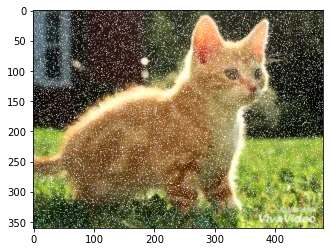

In [68]:
generate_constant_noise(img)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

**OpenCV реализация**

In [69]:
start_time = time.time()
img_cv = cv2.GaussianBlur(img,(5,5),0)
end_time = time.time()

**Изображение**

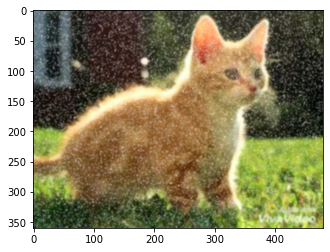

In [70]:
plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))

**Время работы**

In [71]:
print(end_time - start_time)

0.0009980201721191406


**Собственная реализация фильтра Гаусса**

In [72]:
def convolution(img, kernel):
    image_h = img.shape[0]
    image_w = img.shape[1]    
    
    kernel_h = kernel.shape[0]
    kernel_w = kernel.shape[1]
    
    image_pad = np.pad(img, pad_width=((kernel_h // 2, kernel_h // 2),(kernel_w // 2, kernel_w // 2)), mode='constant', constant_values=0).astype(np.float32)
    h = kernel_h // 2
    w = kernel_w // 2
    
    image_conv = np.zeros(image_pad.shape)
    
    for i in range(h, image_pad.shape[0] - h):
        for j in range(w, image_pad.shape[1] - w):
            x = image_pad[i - h : i - h + kernel_h, j - w : j - w + kernel_w]
            x = x.flatten() * kernel.flatten()
            image_conv[i][j] = x.sum()
    h_end = -h
    w_end = -w
    
    if(h == 0):
        return image_conv[h :, w : w_end]
    if(w == 0):
        return image_conv[h : h_end, w:]
    return image_conv[h : h_end, w:w_end]

def gaussian_filter(img, sigma):
    kernel_size = 2 * int(4 * sigma + 0.5) + 1
    kernel = np.zeros((kernel_size, kernel_size), np.float32)
    m = kernel_size // 2
    n = kernel_size // 2
    
    for x in range(-m, m + 1):
        for y in range(-n, n + 1):
            x1 = 2 * np.pi * (sigma ** 2)
            x2 = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
            kernel[x + m, y + n] = (1 / x1) * x2
    
    img_filtered = np.zeros_like(img, dtype = np.float32)
    for c in range(3):
        img_filtered[:, :, c] = convolution(img[:, :, c], kernel)
    return (img_filtered.astype(np.uint8))

**Отфильтрованное изображение (sigma = 1)**

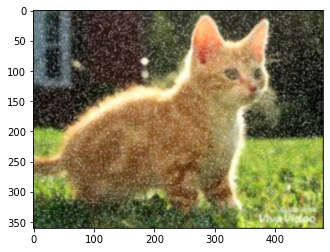

In [81]:
start_time = time.time()
img_gaussian = gaussian_filter(img, 1)
end_time = time.time()
plt.imshow(cv2.cvtColor(img_gaussian, cv2.COLOR_BGR2RGB))

**Время работы**

In [82]:
print(end_time - start_time)

3.580266237258911


**Вычисляем PSNR**

In [83]:
print(psnr(img_cv, img_gaussian))

42.91257104941189


**Отфильтрованное изображение (sigma = 3)**

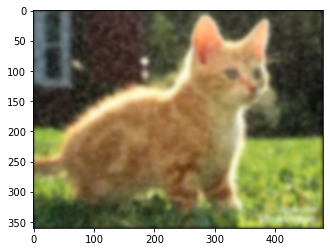

In [84]:
start_time = time.time()
img_gaussian = gaussian_filter(img, 3)
end_time = time.time()
plt.imshow(cv2.cvtColor(img_gaussian, cv2.COLOR_BGR2RGB))

**Время работы**

In [85]:
print(end_time - start_time)

4.601357698440552


**Вычисляем PSNR**

In [86]:
print(psnr(img_cv, img_gaussian))

29.402220086585025
